In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from cardinality_estimation.featurizer import Featurizer
from query_representation.query import load_qrep
from cardinality_estimation.dataset import *
from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt

# Setup file paths / Download query data

In [4]:
import errno
def make_dir(directory):
    try:
        os.makedirs(directory)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

In [5]:
# TODO
# TRAINDIR = os.path.join(os.path.join("", "queries"), "mlsys1-train")
# VALDIR = os.path.join(os.path.join("", "queries"), "mlsys1-val")
# TESTDIR = os.path.join(os.path.join("", "queries"), "mlsys1-test")

TRAINDIR = os.path.join(os.path.join("", "queries"), "imdb")
TESTDIR = os.path.join(os.path.join("", "queries"), "imdb")

RESULTDIR = os.path.join("", "results")
make_dir(RESULTDIR)

# Query loading helper functions

In [6]:

def load_qdata(fns):
    qreps = []
    for qfn in fns:
        qrep = load_qrep(qfn)
        # TODO: can do checks like no queries with zero cardinalities etc.
        qreps.append(qrep)
        template_name = os.path.basename(os.path.dirname(qfn))
        qrep["name"] = os.path.basename(qfn)
        qrep["template_name"] = template_name
    return qreps

def get_query_fns(basedir, template_fraction=1.0, sel_templates=None):
    fns = []
    tmpnames = list(glob.glob(os.path.join(basedir, "*")))
    assert template_fraction <= 1.0
    
    for qi,qdir in enumerate(tmpnames):
        if os.path.isfile(qdir):
            continue
        template_name = os.path.basename(qdir)
        if sel_templates is not None and template_name not in sel_templates:
            continue
        
        # let's first select all the qfns we are going to load
        qfns = list(glob.glob(os.path.join(qdir, "*.pkl")))
        qfns.sort()
        num_samples = max(int(len(qfns)*template_fraction), 1)
        random.seed(1234)
        qfns = random.sample(qfns, num_samples)
        fns += qfns
    return fns

# Evaluation helper functions

In [7]:
def get_preds(alg, qreps):
    if isinstance(qreps[0], str):
        # only file paths sent
        qreps = load_qdata(qreps)
    
    ests = alg.test(qreps)
    return ests

def eval_alg(alg, eval_funcs, qreps, samples_type, result_dir="./results/"):
    '''
    '''
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

    alg_name = alg.__str__()
    exp_name = alg.get_exp_name()
    
    if isinstance(qreps[0], str):
        # only file paths sent
        qreps = load_qdata(qreps)
    
    ests = alg.test(qreps)

    for efunc in eval_funcs:
        rdir = None
        if result_dir is not None:
            rdir = os.path.join(result_dir, exp_name)
            make_dir(rdir)

        errors = efunc.eval(qreps, ests, samples_type=samples_type,
                result_dir=rdir,
                num_processes = -1,
                alg_name = alg_name,
                use_wandb=0)

        print("{}, {}, #samples: {}, {}: mean: {}, median: {}, 99p: {}"\
                .format(samples_type, alg, len(errors),
                    efunc.__str__(),
                    np.round(np.mean(errors),3),
                    np.round(np.median(errors),3),
                    np.round(np.percentile(errors,99),3)))

# Load queries

In [8]:
# set template_fraction <= 1.0 to test quickly w/ smaller datasets
# train_qfns = get_query_fns(TRAINDIR, template_fraction = 0.001)
# val_qfns = get_query_fns(VALDIR, template_fraction = 1.0)
# test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0)

train_qfns = get_query_fns(TRAINDIR, template_fraction = 1.0, sel_templates=["2b"])
val_qfns = []
test_qfns = get_query_fns(TESTDIR, template_fraction = 1.0, sel_templates=["2a"])

print("Selected {} training queries, {} validation queries, {} test queries".\
      format(len(train_qfns), len(val_qfns), len(test_qfns)))

Selected 500 training queries, 0 validation queries, 888 test queries


In [9]:
from evaluation.eval_fns import QError, SimplePlanCost
EVAL_FNS = []
EVAL_FNS.append(QError())
EVAL_FNS.append(SimplePlanCost())

In [10]:
def init_featurizer(featurization_type):
    # Load database specific data, e.g., information about columns, tables etc.
    dbdata_fn = os.path.join(TRAINDIR, "dbdata.json")
    featurizer = Featurizer(None, None, None, None, None)
    with open(dbdata_fn, "r") as f:
        dbdata = json.load(f)
    featurizer.update_using_saved_stats(dbdata)

    featurizer.setup(ynormalization="log",
        feat_separate_alias = 0,
        onehot_dropout = onehot_dropout,
        feat_mcvs = 0,
        heuristic_features = 1,
        featurization_type=featurization_type,
        table_features=1,
        flow_features = 0,
        join_features= "onehot",
        set_column_feature= "onehot",
        max_discrete_featurizing_buckets=30,
        max_like_featurizing_buckets=10,
        embedding_fn = "none",
        embedding_pooling = None,
        implied_pred_features = 0,
        feat_onlyseen_preds = 1)
    featurizer.update_ystats(trainqs)
    
    featurizer.update_workload_stats(trainqs)
    featurizer.init_feature_mapping()
    featurizer.update_ystats(trainqs)

    # if feat_onlyseen_preds:
    # just do it always
    featurizer.update_seen_preds(trainqs)
    
    return featurizer

In [11]:
# going to start training the models
trainqs = load_qdata(train_qfns)

In [12]:
testqs = load_qdata(test_qfns)

In [15]:
max_epochs = 60
lr=0.0001
training_opt = "none"
opt_lr = 0.1
swa_start = 5
mask_unseen_subplans = 0
subplan_level_outputs=0
normalize_flow_loss = 1
heuristic_unseen_preds = 0
cost_model = "C"
use_wandb = 0
eval_fns = "qerr,plancost"
load_padded_mscn_feats = 1
mb_size = 1024
weight_decay = 0.0
load_query_together = 0
result_dir = "./results"
onehot_dropout=0
onehot_mask_truep=0.8
onehot_reg=0
onehot_reg_decay=0.1
eval_epoch = 200
optimizer_name="adamw"
clip_gradient=20.0
loss_func_name = "mse"
hidden_layer_size = 128
num_hidden_layers = 2

In [16]:
# from cardinality_estimation.fcnn import FCNN
# featurizer = init_featurizer("combined")
# #featurizer = init_featurizer("set")

# fcnn = FCNN(max_epochs = max_epochs, lr=lr,
#                 training_opt = training_opt,
#                 opt_lr = opt_lr,
#                 swa_start = swa_start,
#                 mask_unseen_subplans = mask_unseen_subplans,
#                 subplan_level_outputs=subplan_level_outputs,
#                 normalize_flow_loss = normalize_flow_loss,
#                 heuristic_unseen_preds = heuristic_unseen_preds,
#                 onehot_dropout=onehot_dropout,
#                 onehot_reg=onehot_reg,
#                 onehot_reg_decay=onehot_reg_decay,
#                 cost_model = cost_model,
#                 eval_fns = eval_fns,
#                 use_wandb = use_wandb,
#                 mb_size = mb_size,
#                 weight_decay = weight_decay,
#                 load_query_together = load_query_together,
#                 result_dir = result_dir,
#                 num_hidden_layers=num_hidden_layers,
#                 eval_epoch = eval_epoch,
#                 optimizer_name=optimizer_name,
#                 clip_gradient=clip_gradient,
#                 loss_func_name = loss_func_name,
#                 hidden_layer_size = hidden_layer_size)

# fcnn.train(trainqs, valqs=None, testqs=None,
#     featurizer=featurizer, result_dir=RESULTDIR)

In [17]:
# # # evaluate model
# eval_alg(fcnn, EVAL_FNS, trainqs, "train")
# # eval_alg(fcnn, EVAL_FNS, valqs, "val")

# # # TODO: test set prdictions; should submit these for the leaderboard?
# # #preds = fcnn.test(testqs)

In [18]:
from cardinality_estimation.mscn import MSCN as MSCN2

featurizer = init_featurizer("set")
mscn = MSCN2(max_epochs = max_epochs, lr=lr,
                training_opt = training_opt,
                inp_dropout = 0.0,
                hl_dropout = 0.0,
                comb_dropout = 0.0,
                opt_lr = opt_lr,
                swa_start = swa_start,
                mask_unseen_subplans = mask_unseen_subplans,
                subplan_level_outputs=subplan_level_outputs,
                normalize_flow_loss = normalize_flow_loss,
                heuristic_unseen_preds = heuristic_unseen_preds,
                cost_model = cost_model,
                use_wandb = use_wandb,
                eval_fns = eval_fns,
                load_padded_mscn_feats = load_padded_mscn_feats,
                mb_size = mb_size,
                weight_decay = weight_decay,
                load_query_together = load_query_together,
                result_dir = result_dir,
                onehot_dropout=onehot_dropout,
                onehot_mask_truep=onehot_mask_truep,
                onehot_reg=onehot_reg,
                onehot_reg_decay=onehot_reg_decay,
                # num_hidden_layers=num_hidden_layers,
                eval_epoch = eval_epoch,
                optimizer_name=optimizer_name,
                clip_gradient=clip_gradient,
                loss_func_name = loss_func_name,
                hidden_layer_size = hidden_layer_size)

mscn.train(trainqs, valqs=None, testqs=None,
    featurizer=featurizer, result_dir=RESULTDIR)

Updated stats to remove alias based columns


KeyboardInterrupt: 

In [90]:
# evaluate model
eval_alg(mscn, EVAL_FNS, trainqs, "train")

#eval_alg(mscn, EVAL_FNS, valqs, "val")
# TODO: test set prdictions; should submit these for the leaderboard?
#preds = mscn.test(testqs)

Experiment name will be:  MSCN1337814871
Extracting features took:  87.62792754173279
train, MSCN, #samples: 145000, QError: mean: 15.376, median: 2.266, 99p: 167.086
train, #samples: 500, plancost relative: 1.525
train, MSCN, #samples: 500, SimplePlanCost: mean: 751931.802, median: 159059.817, 99p: 7860900.337


In [91]:
eval_alg(mscn, EVAL_FNS, testqs, "test")

Extracting features took:  155.68056893348694
test, MSCN, #samples: 257520, QError: mean: 229.663, median: 2.379, 99p: 184.48
test, #samples: 888, plancost relative: 1.237
test, MSCN, #samples: 888, SimplePlanCost: mean: 2614753.078, median: 350951.545, 99p: 39147598.699


In [1]:
# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [2]:
featurizer = init_featurizer("set")
ds = QueryDataset(trainqs[0:10], featurizer,
        True,
        load_padded_mscn_feats=True)
loader = data.DataLoader(ds,
        batch_size=1, shuffle=False,
        collate_fn=mscn_collate_fn_together,
        )

testds = QueryDataset(testqs[0:3], featurizer,
        True,
        load_padded_mscn_feats=True)
testloader = data.DataLoader(testds,
        batch_size=1, shuffle=False,
        collate_fn=mscn_collate_fn_together,
        )

NameError: name 'init_featurizer' is not defined

In [38]:
import sqlparse
sql = trainqs[2]["sql"]
print(sqlparse.format(sql, reindent=True, keyword_case='upper'))

SELECT COUNT(*)
FROM title AS t,
     kind_type AS kt,
     info_type AS it1,
     movie_info AS mi1,
     movie_info AS mi2,
     info_type AS it2,
     cast_info AS ci,
     role_type AS rt,
     name AS n,
     movie_keyword AS mk,
     keyword AS k
WHERE t.id = ci.movie_id
  AND t.id = mi1.movie_id
  AND t.id = mi2.movie_id
  AND t.id = mk.movie_id
  AND k.id = mk.keyword_id
  AND mi1.movie_id = mi2.movie_id
  AND mi1.info_type_id = it1.id
  AND mi2.info_type_id = it2.id
  AND (it1.id in ('5'))
  AND (it2.id in ('18'))
  AND t.kind_id = kt.id
  AND ci.person_id = n.id
  AND ci.role_id = rt.id
  AND (mi1.info in ('Argentina:Atp',
                    'Germany:16',
                    'Iceland:L',
                    'Netherlands:12',
                    'Sweden:15',
                    'UK:15',
                    'USA:Not Rated',
                    'USA:PG-13'))
  AND (mi2.info in ('Argentina',
                    'London, England, UK',
                    'Los Angeles, California,

In [50]:
#iloader = iter(loader)
iloader = iter(testloader)

In [51]:
xbatch,y,info = next(iloader)
print(torch.sum(xbatch["pred"][:,:,20]))
print(torch.sum(xbatch["pred"][:,:,21]))

tensor(135.9713)
tensor(483.6691)


In [52]:
#model.state_dict()

In [53]:
from cardinality_estimation.nets import *
mscn_model = mscn.net
n_out = 1
sfeats = mscn_model.sample_mlp1.in_features
pfeats = mscn_model.predicate_mlp1.in_features
jfeats = mscn_model.join_mlp1.in_features

net = SetConvNoFlow(sfeats,
    pfeats, jfeats,
    128,
    n_out=n_out,
    dropouts=[0.0, 0.0, 0.0])

In [54]:
print(net)
print(mscn_model)
net.load_state_dict(mscn_model.state_dict())

SetConvNoFlow(
  (inp_drop_layer): Dropout(p=0.0, inplace=False)
  (hl_drop_layer): Dropout(p=0.0, inplace=False)
  (combined_drop_layer): Dropout(p=0.0, inplace=False)
  (sample_mlp1): Linear(in_features=9, out_features=128, bias=True)
  (sample_mlp2): Linear(in_features=128, out_features=128, bias=True)
  (predicate_mlp1): Linear(in_features=66, out_features=128, bias=True)
  (predicate_mlp2): Linear(in_features=128, out_features=128, bias=True)
  (join_mlp1): Linear(in_features=9, out_features=128, bias=True)
  (join_mlp2): Linear(in_features=128, out_features=128, bias=True)
  (out_mlp1): Linear(in_features=384, out_features=128, bias=True)
  (out_mlp2): Linear(in_features=128, out_features=1, bias=True)
)
SetConv(
  (inp_drop_layer): Dropout(p=0.0, inplace=False)
  (hl_drop_layer): Dropout(p=0.0, inplace=False)
  (combined_drop_layer): Dropout(p=0.0, inplace=False)
  (sample_mlp1): Linear(in_features=9, out_features=128, bias=True)
  (sample_mlp2): Linear(in_features=128, out_feat

<All keys matched successfully>

In [55]:
torch.sum(xbatch["pred"][:,:,20])

tensor(135.9713)

In [56]:
model = net
model.eval()
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

In [57]:
#xbatch = ds.X[32]
# ig_attr_test = ig.attribute(tuple([xbatch["table"].unsqueeze(0), xbatch["pred"].unsqueeze(0),
#                             xbatch["join"].unsqueeze(0), xbatch["flow"].unsqueeze(0),
#                             xbatch["tmask"].unsqueeze(0), xbatch["pmask"].unsqueeze(0), 
#                                    xbatch["jmask"].unsqueeze(0)]), n_steps=50)
ig_attr_test = ig.attribute(tuple([xbatch["table"], xbatch["pred"],
                            xbatch["join"], 
                            xbatch["tmask"], xbatch["pmask"], 
                                   xbatch["jmask"]]), n_steps=50)
print("ig done")

fa_attr_test = fa.attribute(tuple([xbatch["table"], xbatch["pred"],
                            xbatch["join"],
                            xbatch["tmask"], xbatch["pmask"], 
                                   xbatch["jmask"]]), n_steps=50)
print("fa done")

ig done
fa done


In [62]:
# def get_attr_vecs(curx, curattrs):
#     #idxs = 0
#     xsum = curx.sum(axis=0).sum(axis=0)
#     zero_idxs = xsum == 0
#     curattrs = curattrs[:,:,~zero_idxs]
#     idxs = np.array(range(len(xsum)))[~zero_idxs]
#     curx = curx[:,:,~zero_idxs]
    
#     assert curx.shape == curattrs.shape
    
#     # TODO: avg based on non-zero elements
#     attr_sum = curattrs.sum(axis=0).sum(axis=0)
#     assert attr_sum.shape[0] == curx.shape[-1]
    
#     # TODO: do we need this?
#     #attr_sum = attr_sum / np.linalg.norm(attr_sum, ord=1)
    
#     # TODO: do this or no?
#     curx_nonz = curx != 0
#     xnonzero_sums = curx_nonz.sum(axis=0).sum(axis=0)
#     #xnonzero_sums += 1
#     #print(xnonzero_sums)
#     #print(xnonzero_sums)
#     attr_sum = attr_sum / xnonzero_sums
    
#     return idxs, attr_sum

# def get_mscn_attrs(xbatch, attrs, featurizer, normalize=True):
#     '''
#     returns a vector with x-axis names and attribution values;
#     '''
#     batchsize = xbatch["table"].shape[0]
#     assert batchsize == attrs[0].shape[0]
#     tabidxs, tabattrs = get_attr_vecs(xbatch["table"].detach().numpy(), attrs[0].detach().numpy())
#     predidxs, predattrs = get_attr_vecs(xbatch["pred"].detach().numpy(), attrs[1].detach().numpy())
#     joinidxs, joinattrs = get_attr_vecs(xbatch["join"].detach().numpy(), attrs[2].detach().numpy())
    
#     # TODO: need to do sample_bitmaps
#     tablabels = []
#     for curtabidx in tabidxs:
#         for tab,tidx in featurizer.table_featurizer.items():
#             if tidx == curtabidx:
#                 tablabels.append(tab)
#                 break
#     joinlabels = []
#     for curjidx in joinidxs:
#         for join,jidx in featurizer.join_featurizer.items():
#             found = False
#             if curjidx == jidx:
#                 joinlabels.append(join)
#                 found = True
#                 break
#         if not found:
#             joinlabels.append("unknown")
#     # TODO: join-stats
    
#     predlabels = []
#     colstart,collen = featurizer.featurizer_type_idxs["col_onehot"]
#     # TODO: if stats used
#     #colstatsstart,colstatsend = self.featurizer_type_idxs["col_stats"]
#     cmp_start,cmplen = featurizer.featurizer_type_idxs["cmp_op"]
#     cstart,clen = featurizer.featurizer_type_idxs["constant_continuous"]
#     lstart,llen = featurizer.featurizer_type_idxs["constant_like"]
#     dstart,dlen = featurizer.featurizer_type_idxs["constant_discrete"]
#     hstart,hlen = featurizer.featurizer_type_idxs["heuristic_ests"]
#     #print(hstart, hlen)
#     for pi in predidxs:
#         if pi >= colstart and pi < colstart+collen:
#             found = False
#             for col,colidx in featurizer.columns_onehot_idx.items():
#                 if colidx == pi:
#                     predlabels.append(col)
#                     found = True
#                     break
#             if not found:
#                 print(pi)
#                 predlabels.append("col-unknown")
#         elif pi >= cmp_start and pi < cmp_start+cmplen:
#             predlabels.append("cmp")
#         elif pi == cstart:
#             predlabels.append("<")
#         elif pi == cstart+1:
#             predlabels.append(">")
#         elif pi >= lstart and pi < lstart+llen:
#             predlabels.append("Like-Hash-" + str(pi))
#         elif pi >= dstart and pi < dstart+dlen:
#             predlabels.append("Constant-Hash-" + str(pi))
#         elif pi == hstart:
#             predlabels.append("PostgreSQL Est (Table)")
#         elif pi == hstart+1:
#             predlabels.append("PostgreSQL Est (Subplan)")
    
#     #assert len(predidxs) == len(predlabels)
# #     print(len(predidxs), len(predlabels))
# #     print(predidxs)
# #     print(predlabels)
#     attrs = np.concatenate([tabattrs, joinattrs, predattrs])
#     xlabels = tablabels + joinlabels + predlabels
    
#     if normalize:
#         attrs = attrs / np.linalg.norm(attrs, ord=1)
    
#     #xlabels = list(range(len(attrs)))
#     return xlabels,attrs

In [63]:
def get_attr_vecs(curx, curattrs):
    #idxs = 0
    xsum = curx.sum(axis=0).sum(axis=0)
    zero_idxs = xsum == 0
    curattrs = curattrs[:,:,~zero_idxs]
    idxs = np.array(range(len(xsum)))[~zero_idxs]
    curx = curx[:,:,~zero_idxs]
    
    assert curx.shape == curattrs.shape
    
    # TODO: avg based on non-zero elements
    
    print("attr sum: ", np.sum(curattrs))
    curattrs = np.abs(curattrs)
    print("attr sum after abs: ", np.sum(curattrs))
    
    attr_sum = curattrs.sum(axis=0).sum(axis=0)
    
    assert attr_sum.shape[0] == curx.shape[-1]
    
    # TODO: do we need this?
    #attr_sum = attr_sum / np.linalg.norm(attr_sum, ord=1)
    
    # TODO: do this or no?
    curx_nonz = curx != 0
    
    xnonzero_sums = curx_nonz.sum(axis=0).sum(axis=0)
    
    #TODO?
    attr_sum = attr_sum / xnonzero_sums
    
    return idxs, attr_sum

def get_mscn_attrs(xbatch, attrs, featurizer, normalize=True):
    '''
    returns a vector with x-axis names and attribution values;
    '''
    batchsize = xbatch["table"].shape[0]
    assert batchsize == attrs[0].shape[0]
    tabidxs, tabattrs = get_attr_vecs(xbatch["table"].detach().numpy(), attrs[0].detach().numpy())
    predidxs, predattrs = get_attr_vecs(xbatch["pred"].detach().numpy(), attrs[1].detach().numpy())
    joinidxs, joinattrs = get_attr_vecs(xbatch["join"].detach().numpy(), attrs[2].detach().numpy())
    
    # TODO: need to do sample_bitmaps
    tablabels = []
    for curtabidx in tabidxs:
        for tab,tidx in featurizer.table_featurizer.items():
            if tidx == curtabidx:
                tablabels.append(tab)
                break
    joinlabels = []
    for curjidx in joinidxs:
        for join,jidx in featurizer.join_featurizer.items():
            found = False
            if curjidx == jidx:
                joinlabels.append(join)
                found = True
                break
        if not found:
            joinlabels.append("unknown")
    # TODO: join-stats
    
    predlabels = []
    colstart,collen = featurizer.featurizer_type_idxs["col_onehot"]
    # TODO: if stats used
    #colstatsstart,colstatsend = self.featurizer_type_idxs["col_stats"]
    cmp_start,cmplen = featurizer.featurizer_type_idxs["cmp_op"]
    cstart,clen = featurizer.featurizer_type_idxs["constant_continuous"]
    lstart,llen = featurizer.featurizer_type_idxs["constant_like"]
    dstart,dlen = featurizer.featurizer_type_idxs["constant_discrete"]
    hstart,hlen = featurizer.featurizer_type_idxs["heuristic_ests"]
    #print(hstart, hlen)
    for pi in predidxs:
        if pi >= colstart and pi < colstart+collen:
            found = False
            for col,colidx in featurizer.columns_onehot_idx.items():
                if colidx == pi:
                    predlabels.append(col)
                    found = True
                    break
            if not found:
                print(pi)
                predlabels.append("col-unknown")
        elif pi >= cmp_start and pi < cmp_start+cmplen:
            predlabels.append("cmp")
        elif pi == cstart:
            predlabels.append("<")
        elif pi == cstart+1:
            predlabels.append(">")
        elif pi >= lstart and pi < lstart+llen:
            predlabels.append("Like-Hash-" + str(pi))
        elif pi >= dstart and pi < dstart+dlen:
            predlabels.append("Constant-Hash-" + str(pi))
        elif pi == hstart:
            predlabels.append("PostgreSQL Est (Table)")
        elif pi == hstart+1:
            predlabels.append("PostgreSQL Est (Subplan)")
    
    #assert len(predidxs) == len(predlabels)
#     print(len(predidxs), len(predlabels))
#     print(predidxs)
#     print(predlabels)
    attrs = np.concatenate([tabattrs, joinattrs, predattrs])
    xlabels = tablabels + joinlabels + predlabels
    
    if normalize:
        attrs = attrs / np.linalg.norm(attrs, ord=1)
    
    return xlabels,attrs

In [64]:
xlabels, igattrs = get_mscn_attrs(xbatch, ig_attr_test, featurizer, normalize=True)
xlabels, fattrs = get_mscn_attrs(xbatch, fa_attr_test, featurizer, normalize=True)
print(xlabels)
print(igattrs)

attr sum:  3.0679268747802064
attr sum after abs:  22.030997184594455
attr sum:  -19.31870633789822
attr sum after abs:  211.6767950925135
attr sum:  1.883283045884235
attr sum after abs:  14.246767081282604
18
attr sum:  -0.38452566
attr sum after abs:  20.053677
attr sum:  30.662582
attr sum after abs:  199.71732
attr sum:  -0.30912447
attr sum after abs:  16.841976
18
['cast_info', 'info_type', 'keyword', 'kind_type', 'movie_info', 'movie_keyword', 'name', 'role_type', 'title', 'ci.movie_id,t.id', 'ci.person_id,n.id', 'ci.role_id,rt.id', 'it.id,mi.info_type_id', 'k.id,mk.keyword_id', 'kt.id,t.kind_id', 'mi.movie_id,mi.movie_id', 'mi.movie_id,t.id', 'mk.movie_id,t.id', 'cmp', 'cmp', 'kt.kind', 'mii.info', 'n.gender', 'n.name_pcode_cf', 't.title', 'col-unknown', '<', '>', 'Constant-Hash-39', 'Constant-Hash-40', 'Constant-Hash-41', 'Constant-Hash-42', 'Constant-Hash-44', 'Constant-Hash-48', 'Constant-Hash-52', 'Constant-Hash-53', 'Constant-Hash-57', 'Constant-Hash-59', 'Constant-Hash-6

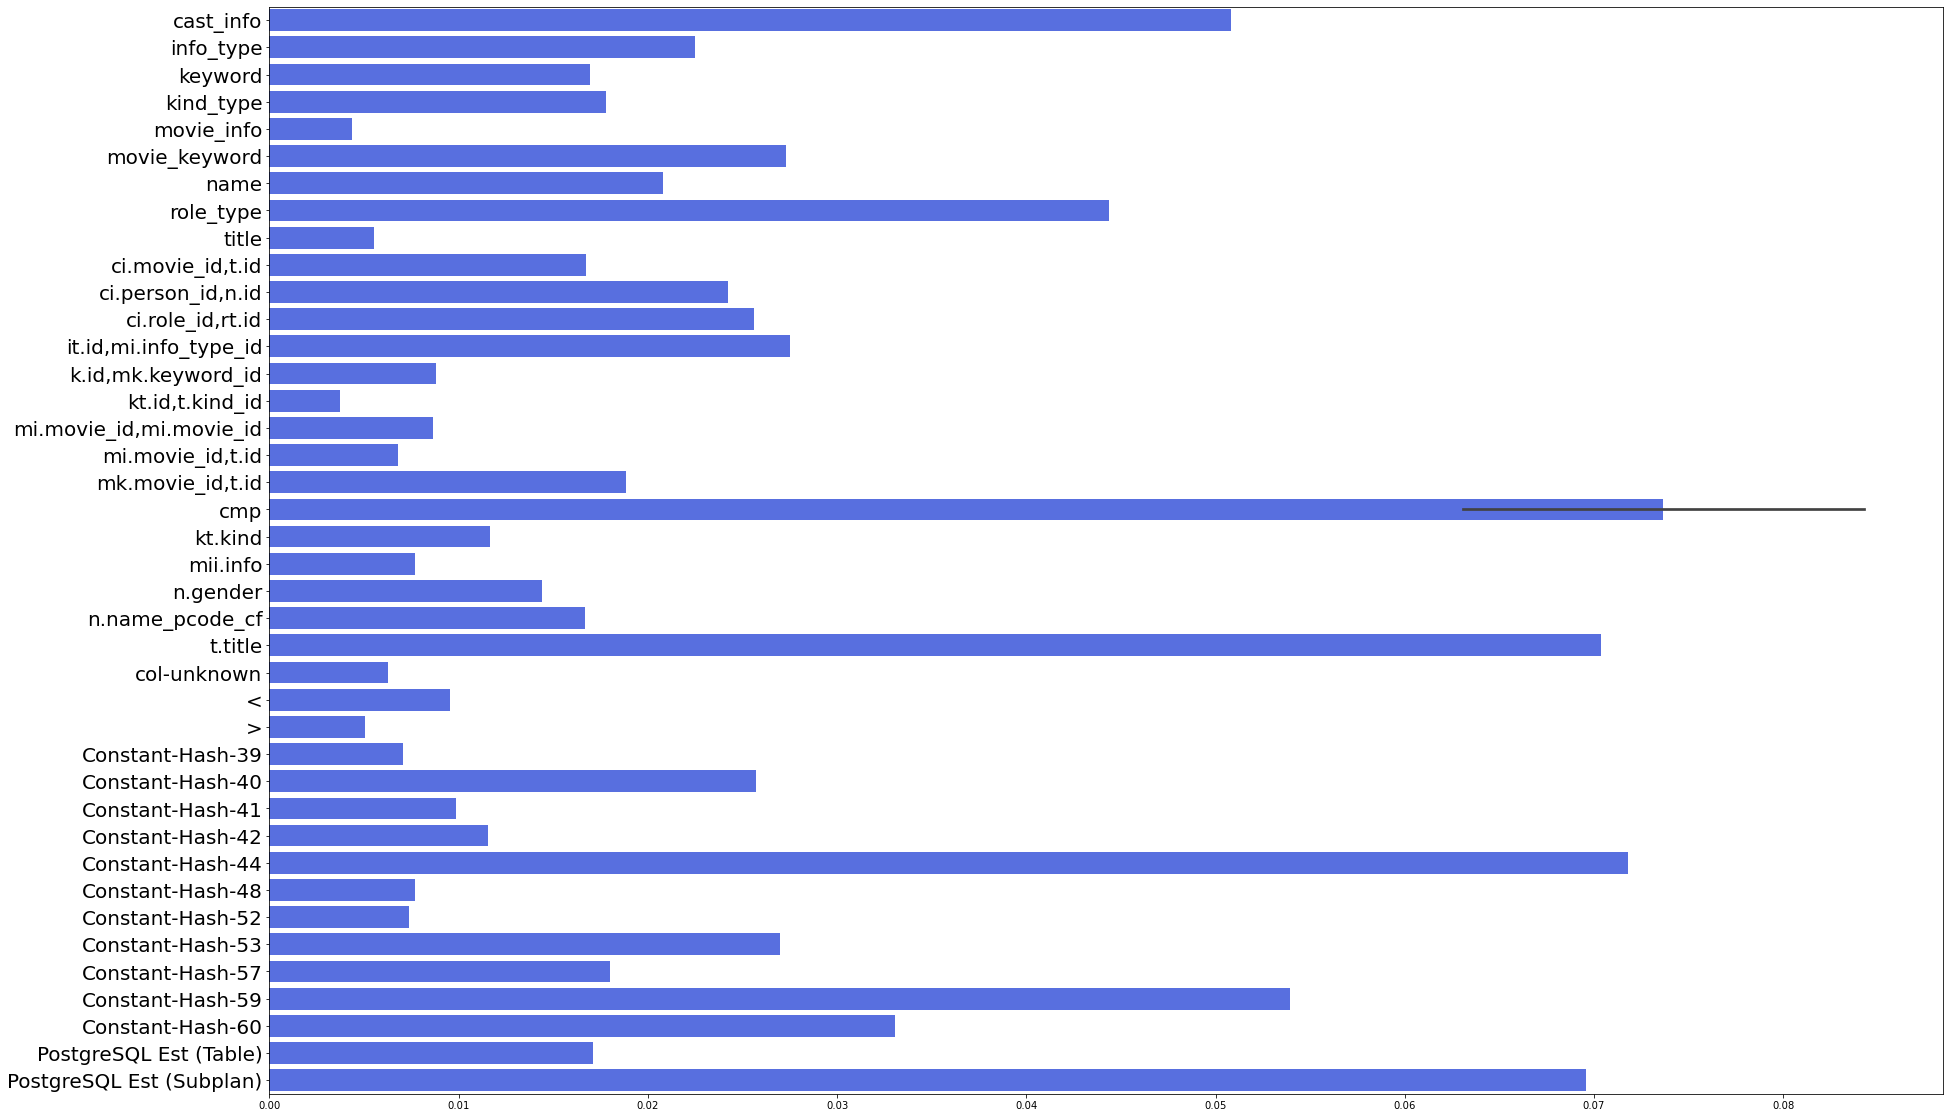

In [65]:
import seaborn as sns

# plt.figure(figsize=(30, 10))
# sns.barplot(x=xlabels, y=igattrs, color='#4260f5')

plt.figure(figsize=(30, 20))
plt.yticks(fontsize=20)
sns.barplot(x=igattrs, y=xlabels, color='#4260f5', orient="horizontal")
plt.savefig("captum-mscn-dropout-2b.png")

<AxesSubplot:>

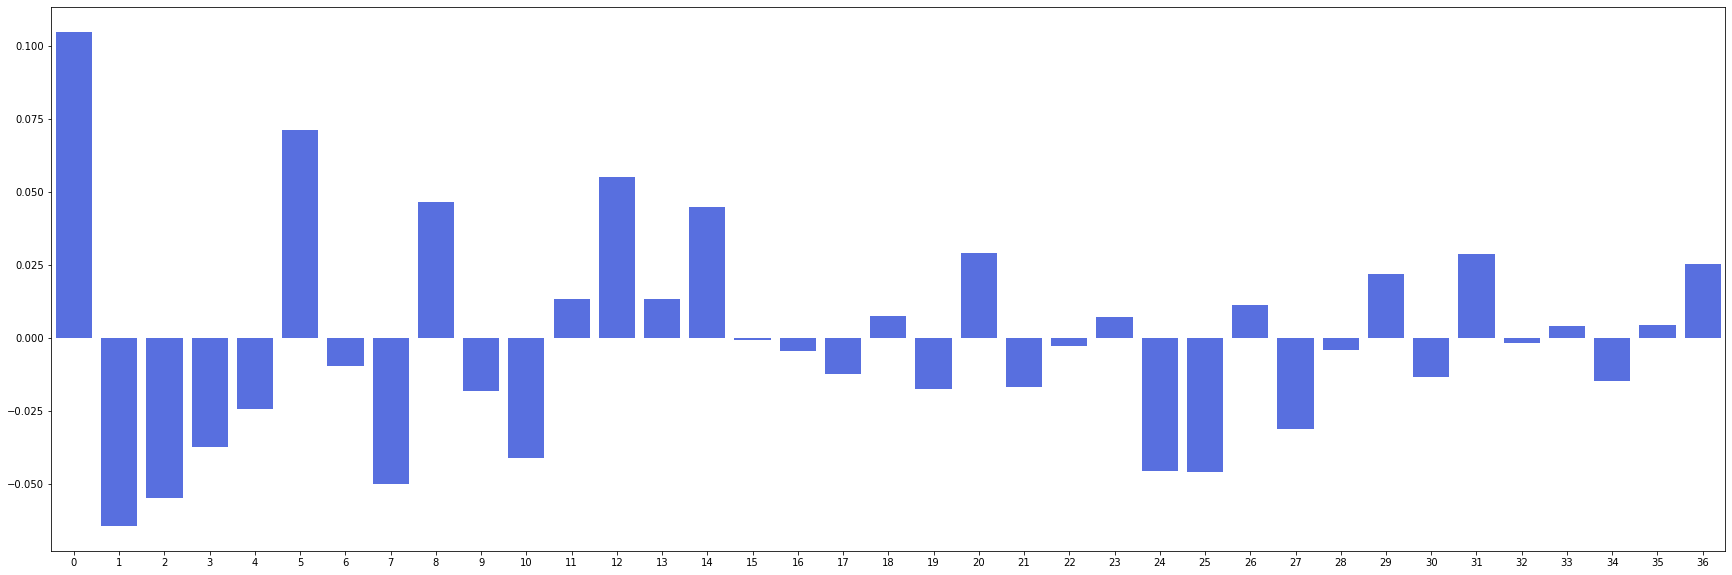

In [135]:
import seaborn as sns

plt.figure(figsize=(30, 10))
sns.barplot(x=xlabels, y=fattrs, color='#4260f5')

In [63]:
curattrs = ig_attr_test[0].detach().numpy()
print(curattrs.shape)
curattrs.sum(axis=0).sum(axis=0).shape

(290, 11, 9)


(9,)

In [23]:
featurizer.featurizer_type_idxs

{'join_onehot': (0, 9),
 'cmp_op': (0, 2),
 'col_onehot': (2, 18),
 'constant_continuous': (20, 2),
 'constant_like': (22, 12),
 'constant_discrete': (34, 10),
 'heuristic_ests': (44, 2)}

In [107]:
print(xbatch["table"].sum(axis=[0,1]))
print(xbatch["pred"].sum(axis=[0,1]))
print(xbatch["join"].sum(axis=[0,1]))

print(xbatch["table"].shape)
print(xbatch["pred"].shape)
print(xbatch["join"].shape)

tensor([220., 188.,  92., 136., 372., 182., 111., 111., 270.])
tensor([1010.0000,  540.0000,    0.0000,    0.0000,    0.0000,    0.0000,
         188.0000,   92.0000,  136.0000,  372.0000,    0.0000,  111.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,  111.0000,
         540.0000,    0.0000,    0.0000,  524.4604,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,  203.0000,    0.0000,
         186.0000,  186.0000,  322.0000,  203.0000,  230.0000,    0.0000,
         414.0000,  389.0000,  658.0579,  540.9561])
tensor([216., 110., 110., 186.,  91., 135., 124., 360., 180.])
torch.Size([290, 11, 9])
torch.Size([290, 11, 46])
torch.Size([290, 11, 9])


In [46]:
# import torch
# print(torch.max(ig_attr_test[1]), torch.argmax(ig_attr_test[1]))
# print(torch.max(fa_attr_test[1]), torch.argmax(fa_attr_test[1]))
#len(ig_attr_test)

# np.linalg.norm(ig_attr_test[1].detach().numpy(), ord=0)

In [95]:
ig_attr_test[1].shape

torch.Size([587, 18, 48])

In [98]:
torch.sum(ig_attr_test[1][:,:,idx])

tensor(8.3609, dtype=torch.float64)

In [90]:
for idx in range(ig_attr_test[1].shape[2]):
    print(idx, torch.sum(ig_attr_test[1][:,:,idx]))

0 tensor(0., dtype=torch.float64)
1 tensor(-1.4279, dtype=torch.float64)
2 tensor(0.3491, dtype=torch.float64)
3 tensor(-0.6830, dtype=torch.float64)
4 tensor(0., dtype=torch.float64)
5 tensor(0., dtype=torch.float64)
6 tensor(0., dtype=torch.float64)
7 tensor(0., dtype=torch.float64)
8 tensor(-1.0535, dtype=torch.float64)
9 tensor(0., dtype=torch.float64)
10 tensor(0.1581, dtype=torch.float64)
11 tensor(-0.1236, dtype=torch.float64)
12 tensor(0., dtype=torch.float64)
13 tensor(0., dtype=torch.float64)
14 tensor(0., dtype=torch.float64)
15 tensor(0., dtype=torch.float64)
16 tensor(0., dtype=torch.float64)
17 tensor(0., dtype=torch.float64)
18 tensor(-0.0802, dtype=torch.float64)
19 tensor(0.3326, dtype=torch.float64)
20 tensor(1.4211, dtype=torch.float64)
21 tensor(0., dtype=torch.float64)
22 tensor(0., dtype=torch.float64)
23 tensor(0.8621, dtype=torch.float64)
24 tensor(0., dtype=torch.float64)
25 tensor(-0.0369, dtype=torch.float64)
26 tensor(0., dtype=torch.float64)
27 tensor(0.697

In [26]:
featurizer = init_featurizer("combined")
ds = QueryDataset(trainqs, featurizer,
        False,
        load_padded_mscn_feats=False)

# featurizer = init_featurizer("set")
# ds = QueryDataset(trainqs, featurizer,
#         False,
#         load_padded_mscn_feats=True)
model = fcnn.net

ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

Updated stats to remove alias based columns
max pred vals: 47
Extracting features took:  0.8985092639923096


In [29]:
X_test = ds.X[32:35]
X_train = ds.X[32:35]

ig_attr_test = ig.attribute(X_test, n_steps=50)
print("ig done")
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
print("dl done")
gs_attr_test = gs.attribute(X_test, X_train)
print("gs done")
fa_attr_test = fa.attribute(X_test)

ig done
dl done
gs done


In [30]:
ig_attr_test

tensor([[ 0.0052,  0.0004, -0.0084,  ..., -0.0000, -0.0000,  0.0000],
        [ 0.0059, -0.0002, -0.0072,  ..., -0.0000,  0.0000,  0.0000],
        [ 0.0064,  0.0005, -0.0060,  ..., -0.0000,  0.0000,  0.0000]],
       dtype=torch.float64)

In [31]:
X_test.shape

torch.Size([3, 421])

In [32]:
# lets find all the zeros in X_test
combined_vec = X_test.sum(axis=0)
zero_idxs = combined_vec == 0
X_test_nonzero = X_test[:,~zero_idxs]
ig_attr_test = ig_attr_test[:,~zero_idxs]
ig_nt_attr_test = ig_nt_attr_test[:,~zero_idxs]
dl_attr_test = dl_attr_test[:,~zero_idxs]
gs_attr_test = gs_attr_test[:,~zero_idxs]
fa_attr_test = fa_attr_test[:,~zero_idxs]

In [33]:
model = fcnn.net

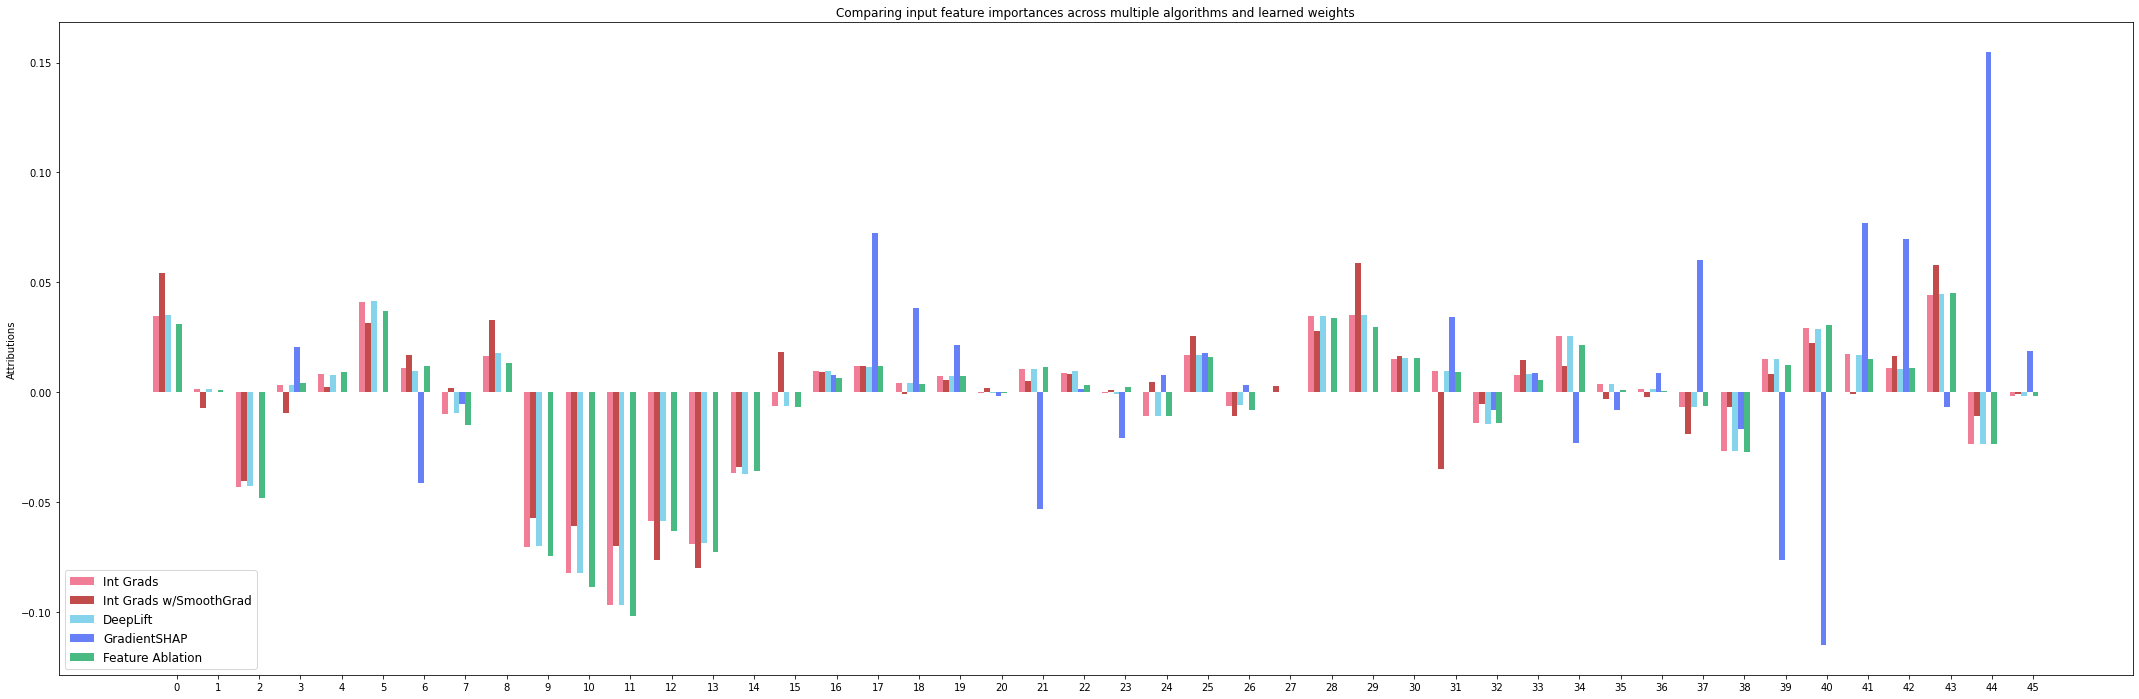

In [34]:
x_axis_data = np.arange(X_test_nonzero.shape[1])
x_axis_data_labels = list(map(lambda idx: idx, x_axis_data))

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

ig_nt_attr_test_sum = ig_nt_attr_test.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

lin_weight = model.layers[0][0].weight.detach().numpy()
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)

width = 0.14
legends = ['Int Grads', 'Int Grads w/SmoothGrad','DeepLift', 'GradientSHAP', 'Feature Ablation', 'Weights']

plt.figure(figsize=(30, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ig_nt_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

#ax.bar(x_axis_data + 5 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

In [35]:
np.linalg.norm(dl_attr_test_sum, ord=1)

0.506443

In [36]:
dl_attr_test_sum

array([ 1.78577974e-02,  7.52312480e-04, -2.15418749e-02,  1.60384004e-03,
        3.93935945e-03,  2.10877899e-02,  5.00810985e-03, -4.73901583e-03,
        9.00274515e-03, -3.54326069e-02, -4.15623412e-02, -4.89440188e-02,
       -2.96287537e-02, -3.48007679e-02, -1.88754369e-02, -3.20775202e-03,
        4.94512729e-03,  5.79412980e-03,  2.06019240e-03,  3.83375585e-03,
       -1.43896366e-04,  5.30758593e-03,  4.92963661e-03, -3.56053235e-04,
       -5.43375639e-03,  8.57877079e-03, -2.99923914e-03, -7.88905072e-06,
        1.75159983e-02,  1.79213695e-02,  7.95027241e-03,  4.83776862e-03,
       -7.29555869e-03,  4.20464342e-03,  1.29278135e-02,  1.96822360e-03,
        8.37280473e-04, -3.36124818e-03, -1.34830289e-02,  7.66214449e-03,
        1.45313442e-02,  8.65940098e-03,  5.48160682e-03,  2.26582885e-02,
       -1.19667305e-02, -8.05790187e-04], dtype=float32)

In [38]:
dl_attr_test.sum(0)

tensor([ 1.7858e-02,  7.5231e-04, -2.1542e-02,  1.6038e-03,  3.9394e-03,
         2.1088e-02,  5.0081e-03, -4.7390e-03,  9.0027e-03, -3.5433e-02,
        -4.1562e-02, -4.8944e-02, -2.9629e-02, -3.4801e-02, -1.8875e-02,
        -3.2078e-03,  4.9451e-03,  5.7941e-03,  2.0602e-03,  3.8338e-03,
        -1.4390e-04,  5.3076e-03,  4.9296e-03, -3.5605e-04, -5.4338e-03,
         8.5788e-03, -2.9992e-03, -7.8891e-06,  1.7516e-02,  1.7921e-02,
         7.9503e-03,  4.8378e-03, -7.2956e-03,  4.2046e-03,  1.2928e-02,
         1.9682e-03,  8.3728e-04, -3.3612e-03, -1.3483e-02,  7.6621e-03,
         1.4531e-02,  8.6594e-03,  5.4816e-03,  2.2658e-02, -1.1967e-02,
        -8.0579e-04], grad_fn=<SumBackward1>)